In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import ipywidgets as wg
import IPython.display
import pandas as pd
import numpy as np
from scipy import signal
from scipy.signal import get_window
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.tsatools import freq_to_period
import math
import warnings
import copy
warnings.filterwarnings("ignore")

class STF_reflected:

    # init method or constructor 
    def __init__(self, data, window, period = None, pad = None, seasonal = None):
        self.data = data
        self.observed = pd.Series(self.data.squeeze(), self.data.index)
        self.window = window
        if period is None:
            freq = None
            if isinstance(data, (pd.Series, pd.DataFrame)):
                freq = getattr(data.index, 'inferred_freq', None)
            if freq is None:
                raise ValueError("Unable to determine period from data")
            period = freq_to_period(freq)
        self.period = period
        self._observed = data
        self.pad = pad
        if seasonal is not None:
            if seasonal % 2 == 0 or seasonal < 3:
                raise ValueError("seasonal must be an odd positive integer >= 3")
        self.seasonal = seasonal
     
    def fit(self):        
        dt = 1 / (self.period)
        t = np.array(self.data.index)

        f = np.array(self.data.squeeze())
        half = int(np.floor(len(t)/2))
        
        # Reflect half of f on both tails 
        reflected = np.append(np.flip(f[0:half]), f)
        reflected = np.append(reflected, np.flip(f[half:len(f)]))
        
        n = len(reflected) 
        # Compute FFT
        # fhat contains complex fourier coefficients with magnitude and phase components
        # The magnitude tells you how important the term is to the signal
        # The phase tells you if the terms is more cosine or sine
        self.fhat = np.fft.fft(reflected, n)
        self.fhat_seasonal = copy.copy(self.fhat)

        if self.window == "tukey":
            window = signal.tukey(n, alpha = self.pad)
        else:
            window = get_window(self.window, n)
        
        # X axis of freqs
        self.freq = (1 / (dt*n)) * np.arange(n)

        # Apply window to freqs
        self.freq = self.freq*window

        # Filter freqs for trend (low pass filter from Celevaland 1990) 
        filter_cutoff = 1.5*(1/self.seasonal)*(1/self.period)

        self.fhat[self.freq >= filter_cutoff] = 0
        # Filter freqs for seasonal (high pass filter)
        self.fhat_seasonal[self.freq < filter_cutoff] = 0

        # Inverse FFT for filtered time signal
        ffilt = np.fft.ifft(self.fhat)
        ffilt_seasonal = np.fft.ifft(self.fhat_seasonal)

        # Remove reflected padding
        ffilt = ffilt[half:(len(f)+half)]
        ffilt_seasonal = ffilt_seasonal[half:(len(f)+half)]

        # Create trend series that can be called after fitting
        trend = pd.Series(ffilt.real, self.data.index, name='trend')
    
        # Create season series that can be called after fitting 
        season = pd.Series(ffilt_seasonal.real, self.data.index, name = 'season')
    
        # Find the residuals 
        resid = pd.Series(self.observed - ffilt_seasonal.real - ffilt.real, self.data.index, name = "resid")
        
        from statsmodels.tsa.seasonal import DecomposeResult
        return DecomposeResult(self._observed, season, trend, resid)

In [10]:
import time

In [11]:
import pandas as pd
from statsmodels.tsa.seasonal import STL
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.datasets import elec_equip as ds
import statsmodels.datasets

--- 0.1360478401184082 seconds ---
--- 0.11703729629516602 seconds ---


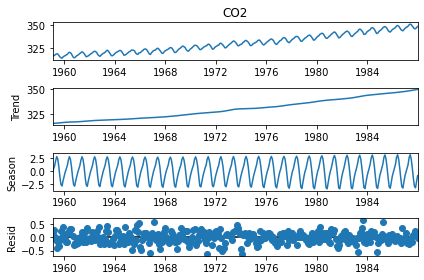

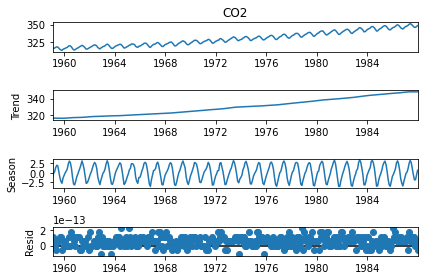

In [12]:
co2 =pd.read_csv('../data/co2.csv', index_col='date', parse_dates=True, squeeze=True)

start_time = time.time()
stl = STL(co2, seasonal=13)
res = stl.fit()
fig = res.plot()
print("--- %s seconds ---" % (time.time() - start_time))

start_time = time.time()
stf = STF_reflected(co2, "blackman", seasonal=13)
res = stf.fit()
fig = res.plot()
print("--- %s seconds ---" % (time.time() - start_time))

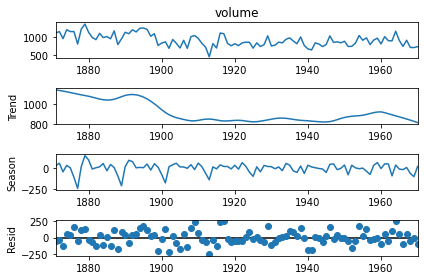

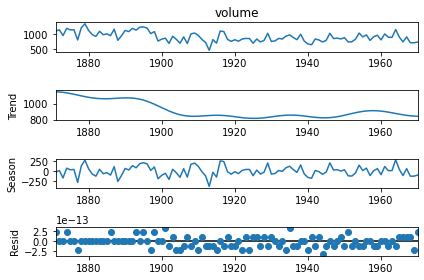

In [13]:
# Test stf vs stl on elec_equip data
data = statsmodels.datasets.nile.load().data

data.index = data["year"]
stl = STL(data["volume"], period = 12, seasonal = 13)
res = stl.fit()
fig = res.plot()

stf = STF_reflected(data["volume"], window="blackman", period = 12, seasonal=13)
res = stf.fit()
fig = res.plot()

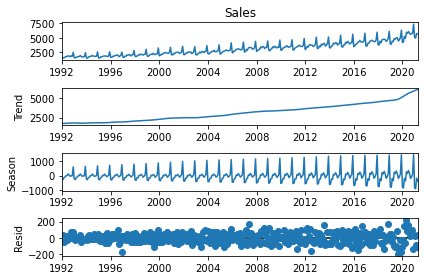

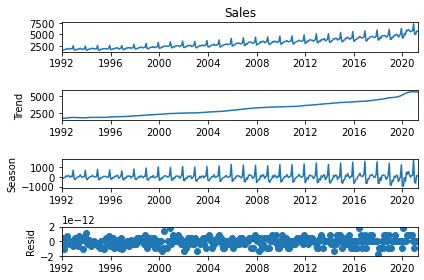

In [14]:
retail =pd.read_csv('../data/RetailSales.csv', index_col="DATE", parse_dates=True, squeeze=True)

stl = STL(retail, seasonal = 13)
res = stl.fit()
fig = res.plot()

stf = STF_reflected(retail, "blackman", pad = .5, seasonal = 13)
res = stf.fit()
fig = res.plot()

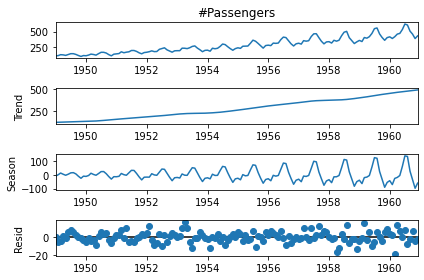

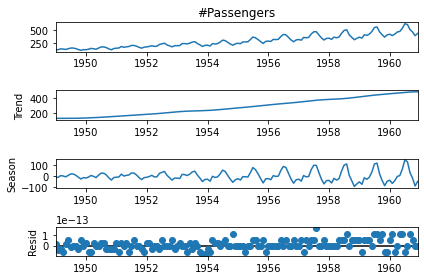

In [15]:
air = pd.read_csv('../data/AirPassengers.csv', index_col = "Month", parse_dates=True, squeeze=True)

stl = STL(air, seasonal = 13)
res = stl.fit()
fig = res.plot()

stf = STF_reflected(air, "blackman", pad = .5, seasonal=13)
res = stf.fit()
fig = res.plot()

--- 19.78127384185791 seconds ---


TypeError: unsupported operand type(s) for /: 'int' and 'NoneType'

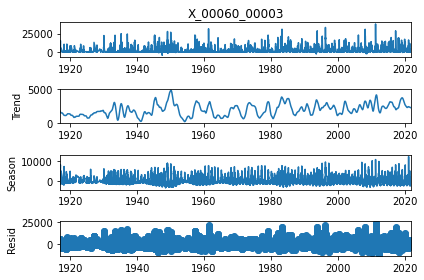

In [16]:
streamflow = pd.read_csv("../data/big_muddy_streamflow.csv", index_col="Date", parse_dates=True)

streamflow = streamflow["X_00060_00003"]
start_time = time.time()
stl = STL(streamflow, period = 365)
stl.fit().plot()
print("--- %s seconds ---" % (time.time() - start_time))
start_time = time.time()

stf = STF_reflected(streamflow, "blackman", pad = .5, period=365)
res = stf.fit()
fig = res.plot()
print("--- %s seconds ---" % (time.time() - start_time))